In [10]:
import pandas

from matplotlib import pyplot
from deps.logger import logger
from deps.data import load_raw_data, load_data
from hcve_lib.evaluation_functions import c_index
from hcve_lib.data import format_identifier_long
from hcve_lib.visualisation import p
from optuna import Trial
from hcve_lib.tracking import get_completed_runs, get_run_duration
from hcve_lib.tracking import get_latest_run
from hcve_lib.tracking import is_root_run
from hcve_lib.tracking import get_children_runs
import humanize
import pytz
from datetime import datetime
from deps.common import get_variables_cached
from mlflow import get_experiment_by_name

from hcve_lib.utils import split_data
import numpy as np
from hcve_lib.tracking import load_pickled_artifact
from hcve_lib.visualisation import b, h2
import mlflow
import yaml
from toolz.curried import partial
from pandas import DataFrame
import plotly.express as px
from hcve_lib.serialization import to_json_serializable
from hcve_lib.evaluation_functions import compute_metric_groups, get_2_level_groups


logger.setLevel('DEBUG')
pandas.set_option("display.max_columns", None)
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format='retina'
pyplot.rcParams['figure.facecolor'] = 'white'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
data, metadata, X, y = get_variables_cached()

raw_data = load_raw_data()
raw_data_subset = raw_data.loc[data.index]

In [6]:
data = load_data(metadata)
data[data['FUNFHF'].isna()]

Raw data
	n cohorts=21
	n individuals=52,585

[17:01:18] Raw data
	n cohorts=21
	n individuals=52,585

Baseline visit kept
 	n individuals removed=5,529

 	n individuals=47,056

[17:01:18] Baseline visit kept
 	n individuals removed=5,529

 	n individuals=47,056

HF cohorts removed
	n cohorts removed=3: hfgr, timechf, leitzaran
	n individuals removed=1,073

	n cohorts=18
	n individuals=45,983

[17:01:18] HF cohorts removed
	n cohorts removed=3: hfgr, timechf, leitzaran
	n individuals removed=1,073

	n cohorts=18
	n individuals=45,983

No outcome cohorts removed
	n cohorts removed=5: biomarcoeurs, dyda, epath, iblomaved, stophf
	n individuals removed=3,077

	n cohorts=13
	n individuals=42,906

[17:01:18] No outcome cohorts removed
	n cohorts removed=5: biomarcoeurs, dyda, epath, iblomaved, stophf
	n individuals removed=3,077

	n cohorts=13
	n individuals=42,906

Missing HF data cohorts removed
	n cohorts removed=6: adelhyde, gecoh, r2c2, reve(1-2), stanislas, styrianvitd
	n individuals 

,IDNR,STUDY_NUM,STUDY,VISIT,SEX,AGE,BW,BH,BMI,SMK,DRK,DIABETES,HCV,HCAD,HPAD,HAF,HCEREBROV,TRT_AH,TRT_ACE,TRT_CCB,TRT_DIUR,TRT_BB,TRT_ARB,TRT_LIP,SBP,DBP,HR,PP,SOK,QRS,CI,GLU,CHOL,LDL,HDL,TG,CREA,FCV,FUFCV,NFHF,FUNFHF,FNFHF,FUFNFHF
IDNR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


In [7]:
for column in data.columns:
    print(f'{len(data[column].unique())}: {format_identifier_long(column, metadata)}')

32405: [IDNR] IDNR
7: [STUDY_NUM] Numeric study identifier
7: [STUDY] STUDY
1: [VISIT] VISIT
2: [SEX] Gender
16090: [AGE] Age
1878: [BW] Body weight
883: [BH] Body height
13216: [BMI] Body-mass index_frame
4: [SMK] Smoking status
3: [DRK] Alcohol intake
3: [DIABETES] History of diabetes
3: [HCV] History of cardiovascular disease
3: [HCAD] History of coronary artery disease
3: [HPAD] History of peripheral artery disease
3: [HAF] History of atrial fibrillation
3: [HCEREBROV] History of cerebrovascular incident
3: [TRT_AH] Intake of antihypertensive medication
3: [TRT_ACE] Intake of angiotensin converting enzyme inhibitors
3: [TRT_CCB] Intake of calcium channel blockers
3: [TRT_DIUR] Intake of diuretics
3: [TRT_BB] Intake of beta-blokcers
3: [TRT_ARB] Intake of angiotensin II receptor blockers
3: [TRT_LIP] Intake of lipid-lowering medication
471: [SBP] Systolic blood pressure
308: [DBP] Diastolic blood pressure
189: [HR] Heart rate
408: [PP] Pulse pressure
557: [SOK] Sokolow-Lyon index_fr

In [8]:

for column in data.columns:
    if len(data[column].unique()) < 10:
        data.loc[:, column] = data[column].astype('category')
    print(f'{data[column].dtype}: {format_identifier_long(column, metadata)}')

int64: [IDNR] IDNR
category: [STUDY_NUM] Numeric study identifier
category: [STUDY] STUDY
category: [VISIT] VISIT
category: [SEX] Gender
float64: [AGE] Age
float64: [BW] Body weight
float64: [BH] Body height
float64: [BMI] Body-mass index_frame
category: [SMK] Smoking status
category: [DRK] Alcohol intake
category: [DIABETES] History of diabetes
category: [HCV] History of cardiovascular disease
category: [HCAD] History of coronary artery disease
category: [HPAD] History of peripheral artery disease
category: [HAF] History of atrial fibrillation
category: [HCEREBROV] History of cerebrovascular incident
category: [TRT_AH] Intake of antihypertensive medication
category: [TRT_ACE] Intake of angiotensin converting enzyme inhibitors
category: [TRT_CCB] Intake of calcium channel blockers
category: [TRT_DIUR] Intake of diuretics
category: [TRT_BB] Intake of beta-blokcers
category: [TRT_ARB] Intake of angiotensin II receptor blockers
category: [TRT_LIP] Intake of lipid-lowering medication
float

In [9]:
import pickle

with open('./data/prediction.data', 'rb') as file:
    results = pickle.load(file)

/home/sitnarf/.local/share/virtualenvs/homage-fl-Ms4N7PDp/lib/python3.9/site-packages/sklearn/base.py:310: UserWarning:

Trying to unpickle estimator FunctionTransformer from version 0.24.0 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.



# Removed features

In [ ]:
# removed_features = pipe(
    #     result['column_masks'],
    #     valmap(lambda mask: valfilter(identity, mask)),
    #     valmap(lambda mask: list(mask)),
    #     valmap(lambda mask: map(partial(format_identifier, metadata=metadata), mask)),
    #     valmap(lambda mask: list(mask)),
    # )
    # b('Removed features')

# LM matrix

In [17]:


for method_name in ('gb', 'coxnet'):
    h2(method_name)
    runs = mlflow.search_runs(mlflow.get_experiment_by_name('lm').experiment_id)
    print(runs.columns)
    last_run = runs[(runs['tags.mlflow.parentRunId'].isna()) & (runs['tags.method_name'] == method_name)].iloc[0]
    result = load_pickled_artifact(last_run['run_id'], 'result')

    metrics_group = compute_metric_groups(
        partial(c_index, X=X, y=y),
        get_2_level_groups(
            result,
            raw_data_subset.groupby('STUDY'),
            data,
        )
    )

    import plotly.figure_factory as ff
    fig = ff.create_annotated_heatmap(
        DataFrame(metrics_group).round(decimals=2).to_numpy(),
        x=list(metrics_group.keys()),
        y=list(reversed(metrics_group.keys())),
        # font_colors=['#000000', '#ffffff'],
    )
    fig.update_layout(xaxis_title="Trained on", yaxis_title='Tested on')
    fig.show()




31559

In [ ]:
DataFrame(metrics_group).round(decimals=2).to_numpy()

In [ ]:
print(yaml.dump(to_json_serializable(metrics_group)))

# Hyperparams feature importance

In [6]:
from hcve_lib.tracking import get_study
import optuna
from mlflow import set_tracking_uri
from pipelines import get_pipelines
set_tracking_uri('http://localhost:5000')

runs = get_completed_runs('lco_optimized')

for method_name in get_pipelines().keys():
    h2(method_name)
    last_run = get_latest_run(runs, is_root_run(runs) & (runs['tags.method_name'] == method_name))
    study = get_study(last_run['run_id'])
    print(study.best_trial.user_attrs['hyperparameters'])
    optuna.visualization.plot_optimization_history(study).show()


AttributeError: 'NoneType' object has no attribute 'experiment_id'

## Brier scores

In [ ]:
from sksurv.metrics import brier_score

for fold_name, fold in result['predictions'].items():
    b(fold_name)
    try:
        print(brier_score(
            fold['y_train'],
            fold['y_true'],
            [fn(365*5) for fn in fold['model'] \
                .predict_survival_function(fold['X_test'])],
            365*5,
        )[1])
    except Exception as e:
        print(e)

## Survival functions

In [120]:
from numpy import arange

for fold_name, fold in result['predictions'].items():
    pyplot.figure()
    pyplot.title(fold_name)
    y_survival = fold['model'].predict_survival_function(fold['X_test'])
    for step_function in y_survival:
        step_x = list(arange(0, 365*5, step=1))
        pyplot.step(step_x, step_function(step_x), where="post", c='navy', alpha=0.05)
        pyplot.gca().ticklabel_format(useOffset=False, style='plain')
        pyplot.ylabel("est. probability of survival $\hat{S}(t)$")
        pyplot.xlabel("time $t$")
    pyplot.show()

KeyError: 'predictions'

In [ ]:
data, metadata, X, y = get_variables_cached()

In [ ]:
set_tracking_uri('http://localhost:5000')
runs = get_completed_runs('lco_optimized')
last_run = get_latest_run(runs, is_root_run(runs) & (runs['tags.mlflow.runName'] == 'coxnet'))
children = get_children_run(runs, last_run['run_id'])

def get_trial_duration_min(trial: Trial) -> float:
    return (trial.datetime_complete-trial.datetime_start).total_seconds()  / 60

for _, run in children.iterrows():
    b(run['tags.mlflow.runName'])
    p(humanize.naturaltime(datetime.now(tz=pytz.utc) - last_run['start_time']))
    p(f'Total duration: {humanize.naturaldelta(get_run_duration(run))}')
    study = load_pickled_artifact(run['run_id'], 'study')
    # optuna.visualization.plot_optimization_history(study).show()
    # optuna.visualization.plot_param_importances(result).show()
    # optuna.visualization.plot_parallel_coordinate(study).show()
    trial_durations = [
        get_trial_duration_min(trial) for trial in study.trials]
    px.scatter(trial_durations, labels={'index': 'Run', 'value': 'Duration'}).show()
    x = [trial.params['__cross_validate__missing_fraction'] for trial in study.trials]
    y = [trial.value for trial in study.trials]
    # plotly.express.scatter(x=x, y=y).show()

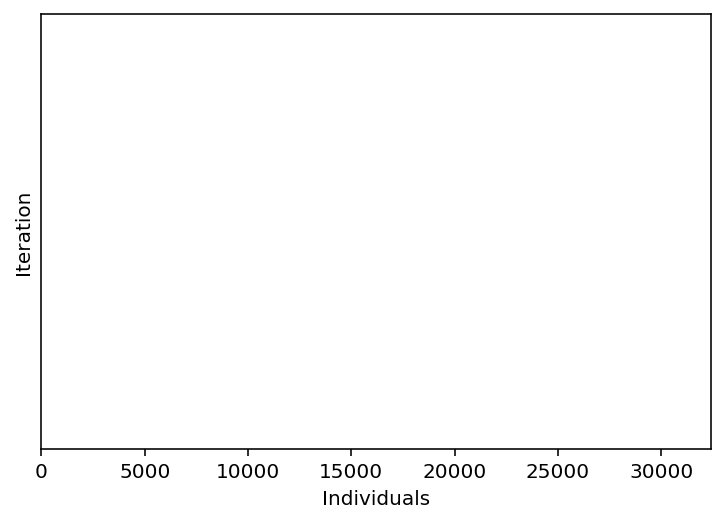

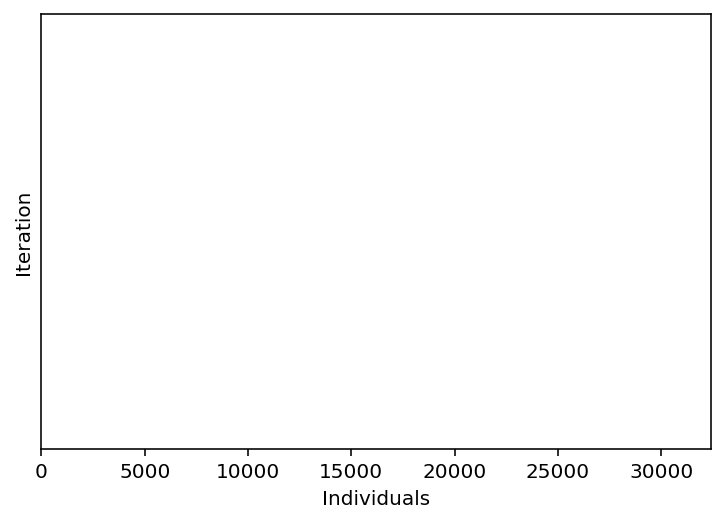

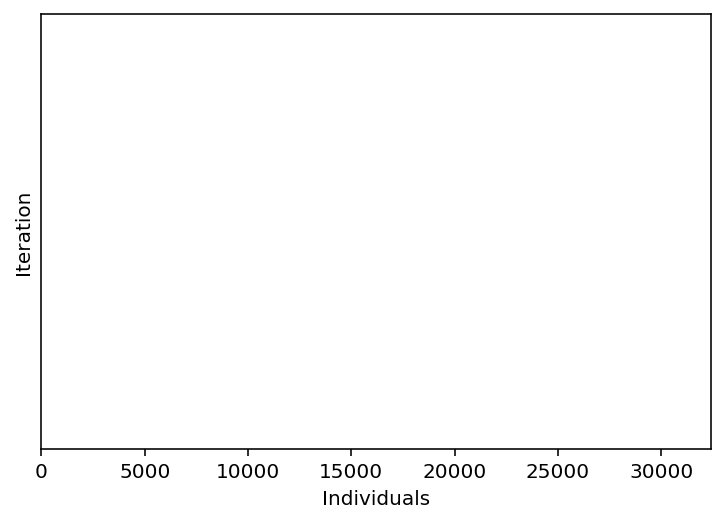

In [200]:
runs_lm = get_completed_runs('lco')
root_runs = runs_lm[is_root_run(runs_lm)]

for run_name in root_runs['tags.mlflow.runName'].unique():
    h2(run_name)
    last_run = get_latest_run(root_runs, root_runs['tags.mlflow.runName'] == run_name)
    last_train_runs = get_children_run(runs_lm, last_run['run_id'])
    X_all_index = data.index

    out = np.ones((len(last_train_runs), len(X_all_index), 3), dtype='float')



    run_names = []
    for number, (index, run) in enumerate(last_train_runs.iterrows()):
        try:
            fold = load_pickled_artifact(run['run_id'], 'fold')
        except OSError as e:
            if str(e).startswith('No such file or directory'):
                continue
            else:
                raise e

        row = X_all_index.to_numpy().copy()
        X_train, y_train, X_test, y_test = split_data(*train_test_fold(data, fold, metadata), fold)
        out[number][np.isin(row, X_train.index)] = (0,1,0)
        out[number][np.isin(row, X_test.index)] = (1,0,0)
        run_names.append(run['tags.mlflow.runName'])

    pyplot.imshow(out, aspect='auto', interpolation='none')
    pyplot.xlabel('Individuals')
    pyplot.yticks(ticks=list(range(len(run_names))), labels=run_names)
    pyplot.ylabel('Iteration')
    pyplot.show()

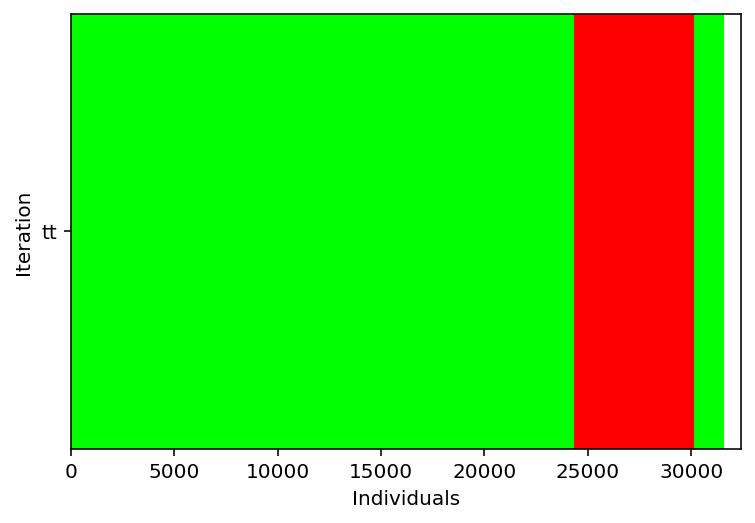

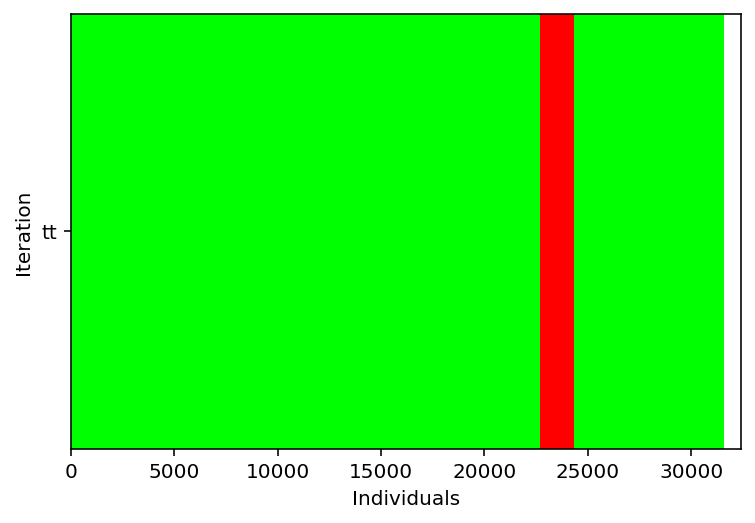

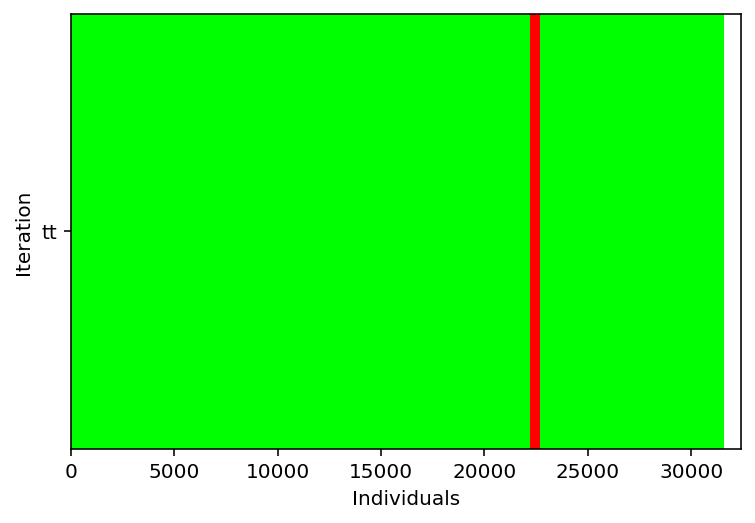

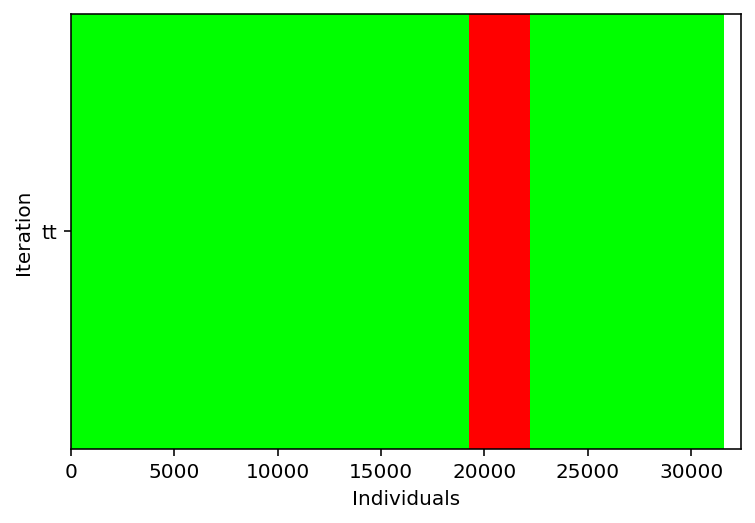

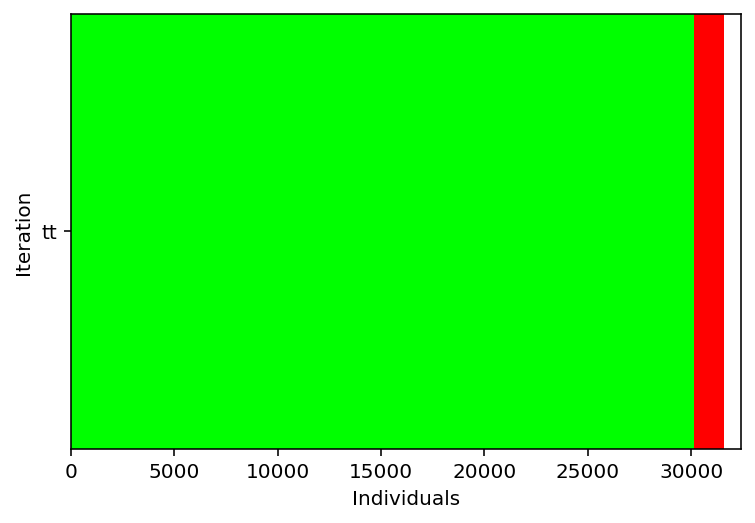

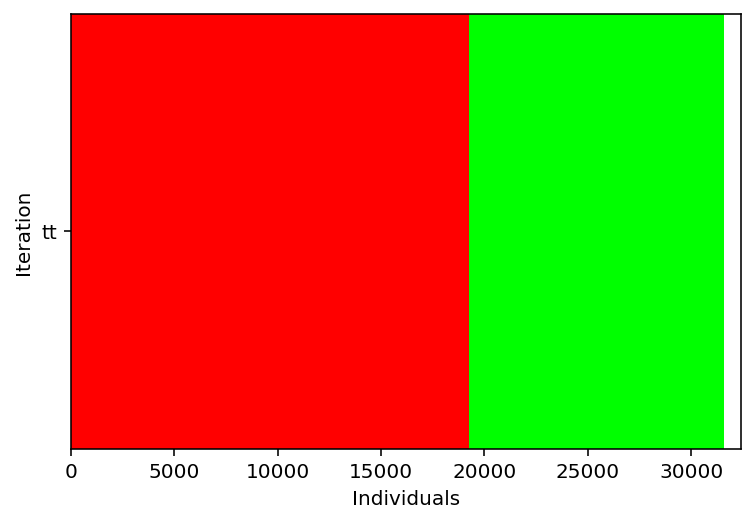

In [219]:


def plot_splits(last_result):
    X_all_index = data.index
    out = np.ones((len(last_result.keys()), len(X_all_index), 3), dtype='float')

    run_names = []
    for number, (name, fold) in enumerate(last_result.items()):
        row = X_all_index.to_numpy().copy()
        X_train, y_train, X_test, y_test = split_data(*train_test_fold(data, fold, metadata), fold)
        out[number][np.isin(row, X_train.index)] = (0,1,0)
        out[number][np.isin(row, X_test.index)] = (1,0,0)
        run_names.append(name)

    pyplot.imshow(out, aspect='auto', interpolation='none')
    pyplot.xlabel('Individuals')
    pyplot.yticks(ticks=list(range(len(run_names))), labels=run_names)
    pyplot.ylabel('Iteration')
    pyplot.show()

# runs = get_completed_runs('lco')
# last_run = runs[is_root_run(runs)].iloc[0]
# last_result = load_pickled_artifact(last_run['run_id'], 'result')
# plot_splits(last_result)

runs = mlflow.search_runs(
        get_experiment_by_name('optimized_lco').experiment_id)
last_root_run = runs[is_root_run(runs)].iloc[0]
nested_runs = get_children_runs(runs, last_root_run.run_id).iloc
for nested_run in nested_runs:
    b(nested_run['tags.mlflow.runName'])
    last_result = load_pickled_artifact(nested_run['run_id'], 'result')
    plot_splits(last_result)

## 10 fold per cohort

In [11]:
import mlflow
from hcve_lib.visualisation import b

runs = mlflow.search_runs(
        get_experiment_by_name('optimized_10_fold_per_study').experiment_id)
last_root_run = runs[is_root_run(runs)].iloc[0]
nested_runs = get_children_runs(runs, last_root_run.run_id).iloc
for nested_run in nested_runs:
    b(nested_run['tags.mlflow.runName'])
    last_result = load_pickled_artifact(nested_run['run_id'], 'result')
    plot_splits(last_result)

OSError: No such file or directory: './mlruns/18/5cbb25b1b7f641f18348a26ff1d3b7a0/artifacts/result'

In [248]:


def get_hyperparameters():
    runs_lco = get_completed_runs('optimized_lco')
    root_lco_runs = runs_lco[is_root_run(runs_lco)]
    coxnet_run = root_lco_runs.query('`tags.mlflow.runName` == "coxnet"').iloc[0]
    children_runs = get_children_runs(runs_lco, coxnet_run['run_id'])
    hyperparameters = {
        rows['tags.mlflow.runName']: rows['params.hyperparameters']
        for _, rows in children_runs.iterrows()
    }
    return hyperparameters

get_hyperparameters()

{'PROSPER': "{'estimator__inner': {'l1_ratio': 0.20680270201087592, 'alphas': [0.8239104031859371]}}",
 'PREDICTOR': "{'estimator__inner': {'l1_ratio': 0.0009829553330933383, 'alphas': [0.5096563050964983]}}",
 'HVC': "{'estimator__inner': {'l1_ratio': 0.31184850394190633, 'alphas': [0.6154208894366343]}}",
 'HEALTHABC': "{'estimator__inner': {'l1_ratio': 0.0008459384094903211, 'alphas': [0.7241804583576157]}}",
 'FLEMENGHO': "{'estimator__inner': {'l1_ratio': 0.20562592215297149, 'alphas': [0.6965683563912647]}}",
 'ASCOT': "{'estimator__inner': {'l1_ratio': 0.00575174141945245, 'alphas': [0.5874297044862964]}}"}